In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf

2024-05-02 13:27:33.677183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Read the weather data from CSV
data = pd.read_csv("weatherHistory.csv")

In [6]:
features = data[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']]
target = data['Precip Type']

In [8]:
# Encode the target variable
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [11]:
#Instantiate the models
input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(input_dim + output_dim, 1)  # Modify the input_dim and output_dim

# Define the loss functions and optimizers
criterion = nn.BCELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

In [10]:
# Define the Generator and Discriminator models
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [17]:
import matplotlib.pyplot as plt

# Lists to store losses
disc_losses = []
gen_losses = []

# Training loop
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    epoch_disc_loss=0.0
    epoch_gen_loss=0.0
    for i in range(0, X_train.shape[0], batch_size):
        # Zero out the gradients
        gen_optimizer.zero_grad()
        disc_optimizer.zero_grad()

        # Get the batch data
        real_features = X_train[i:i + batch_size]
        real_targets = y_train[i:i + batch_size]

        # Generate fake data
        fake_targets = generator(real_features)
        fake_data = torch.cat((fake_targets, real_features), 1)  # Change the concatenation order

        # One-hot encode real targets
        real_targets_onehot = torch.zeros((real_targets.size(0), output_dim), dtype=torch.float32)
        real_targets_onehot.scatter_(1, real_targets.unsqueeze(1), 1)

        real_data = torch.cat((real_targets_onehot, real_features), 1)  # Change the concatenation order

        # Train the discriminator
        disc_real = discriminator(real_data)
        disc_fake = discriminator(fake_data)

        disc_loss_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = (disc_loss_real + disc_loss_fake) / 2

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Train the generator
        fake_targets = generator(real_features)
        fake_data = torch.cat((fake_targets, real_features), 1)  # Change the concatenation order
        gen_output = discriminator(fake_data)
        gen_loss = criterion(gen_output, torch.ones_like(gen_output))

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        # Accumulate losses
        epoch_disc_loss += disc_loss.item()
        epoch_gen_loss += gen_loss.item()

    # Average losses for the epoch
    epoch_disc_loss /= (X_train.shape[0] / batch_size)
    epoch_gen_loss /= (X_train.shape[0] / batch_size)

    # Store epoch losses
    disc_losses.append(epoch_disc_loss)
    gen_losses.append(epoch_gen_loss)

    

    # Print the losses for monitoring
    print(f'Epoch {epoch+1}/{num_epochs}, Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}')



Epoch 1/100, Discriminator Loss: 1.0253, Generator Loss: 0.4923
Epoch 2/100, Discriminator Loss: 0.7815, Generator Loss: 0.6685
Epoch 3/100, Discriminator Loss: 0.6673, Generator Loss: 0.7182
Epoch 4/100, Discriminator Loss: 0.6591, Generator Loss: 0.7368
Epoch 5/100, Discriminator Loss: 0.9223, Generator Loss: 0.5028
Epoch 6/100, Discriminator Loss: 0.4712, Generator Loss: 1.0174
Epoch 7/100, Discriminator Loss: 1.0929, Generator Loss: 0.4212
Epoch 8/100, Discriminator Loss: 0.6461, Generator Loss: 0.7581
Epoch 9/100, Discriminator Loss: 0.4062, Generator Loss: 1.2027
Epoch 10/100, Discriminator Loss: 0.8075, Generator Loss: 0.6240
Epoch 11/100, Discriminator Loss: 0.8669, Generator Loss: 0.5639
Epoch 12/100, Discriminator Loss: 0.7990, Generator Loss: 0.6352
Epoch 13/100, Discriminator Loss: 1.1033, Generator Loss: 0.4590
Epoch 14/100, Discriminator Loss: 0.7573, Generator Loss: 0.5059
Epoch 15/100, Discriminator Loss: 0.7862, Generator Loss: 0.6954
Epoch 16/100, Discriminator Loss: 

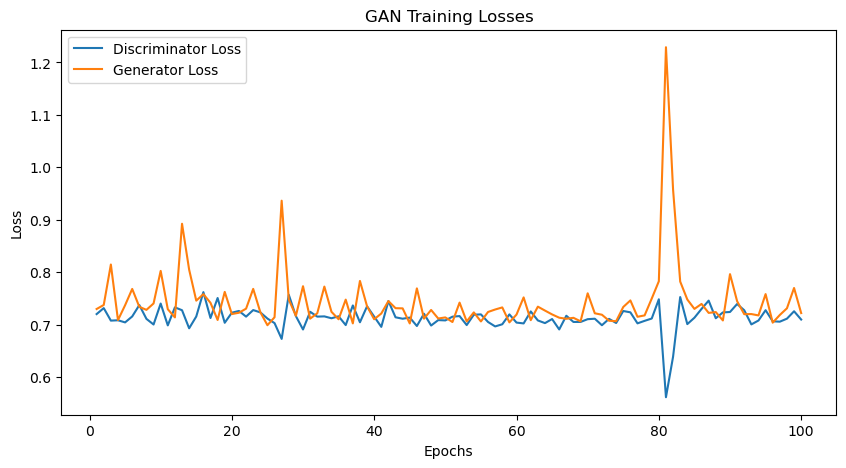

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), disc_losses, label='Discriminator Loss')
plt.plot(range(1, num_epochs+1), gen_losses, label='Generator Loss')
plt.title('GAN Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
generator.eval()
with torch.no_grad():
    test_targets = generator(X_test)
    test_targets = torch.argmax(test_targets, dim=1)
    accuracy = (test_targets == y_test).float().mean()
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8801


In [38]:
import numpy as np

# Initialize list to store generated data
generated_data = []

# Generate synthetic data
with torch.no_grad():
    for i in range(100):  # Generate 100 samples
        fake_targets = generator(X_test)
        fake_data = torch.cat((fake_targets, X_test), 1)
        generated_data.append(fake_data.numpy())

# Convert generated data list to numpy array
generated_data_np = np.array(generated_data)

# Select relevant features from the generated data array
relevant_generated_data_np = generated_data_np[:, :, :7]  # Select the first 7 features


In [39]:
# Load the RNN model from the H5 file
rnn_model = load_model('weather_prediction_model.h5')  

2024-05-02 14:13:26.965534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-02 14:13:26.966511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-02 14:13:26.967222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [40]:
# Select relevant features from the generated data array
relevant_generated_data_np = generated_data_np[:, :7]  # Select the first 7 features

# Reshape the generated data array to match the expected input shape (batch_size, 1, 7)
generated_data_reshaped = relevant_generated_data_np.reshape(-1, 1, 7)

# Make predictions using the loaded RNN model
with tf.device('/CPU:0'):
    rnn_output = rnn_model.predict(generated_data_reshaped)

32/32 [==============================] - 0s 2ms/step


2024-05-02 14:13:28.073617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-02 14:13:28.074718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-02 14:13:28.075498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [47]:
predicted_labels = np.argmax(rnn_output, axis=1)

# Convert y_test to numpy array
y_test_np = y_test.numpy()

# Calculate accuracy
ccuracy = np.mean(predicted_labels == y_test_np)
print(f'Accuracy on the generated data: {accuracy * 100:.2f}%')

Accuracy on the generated data: 88.01%


/tmp/ipykernel_31332/727968535.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ccuracy = np.mean(predicted_labels == y_test_np)
